In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import cv2
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
#load data

# PATH = "/content/drive/.shortcut-targets-by-id/1c4oWg2n6LOBcg55d-i7mk7AHWJ0fN664/CZ4042 Final Project/AdienceBenchmarkGenderAndAgeClassification/"
PATH = "/kaggle/input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/"

data = pd.read_csv(PATH+"fold_0_data.txt",sep = "\t" )
data1 = pd.read_csv(PATH+"fold_1_data.txt",sep = "\t" )
data2 = pd.read_csv(PATH+"fold_2_data.txt",sep = "\t" )
data3 = pd.read_csv(PATH+"fold_3_data.txt",sep = "\t" )
data4 = pd.read_csv(PATH+"fold_4_data.txt",sep = "\t" )

data = pd.concat([data, data1, data2, data3, data4], ignore_index=True)

In [ ]:
df = data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     19370 non-null  object
 1   gender  18591 non-null  object
 2   x       19370 non-null  int64 
 3   y       19370 non-null  int64 
 4   dx      19370 non-null  int64 
 5   dy      19370 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 908.1+ KB


In [ ]:
img_path = []
PATH = "/kaggle/input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/"

for row in data.iterrows():
    path = PATH+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

df['img_path'] = img_path

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='age', ylabel='count'>

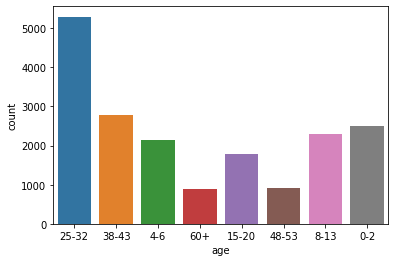

In [ ]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), 
               ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), 
               ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), 
               ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), 
               ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), 
               ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)


sns.countplot(x='age',data=df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


<AxesSubplot:xlabel='gender', ylabel='count'>

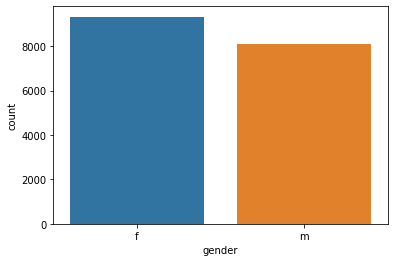

In [ ]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()
sns.countplot(x='gender',data=unbiased_data)

In [ ]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,/kaggle/input/adience-benchmark-gender-and-age...
1,4,1,301,105,640,641,/kaggle/input/adience-benchmark-gender-and-age...
2,4,0,2395,876,771,771,/kaggle/input/adience-benchmark-gender-and-age...
3,4,1,752,1255,484,485,/kaggle/input/adience-benchmark-gender-and-age...
4,4,1,175,80,769,768,/kaggle/input/adience-benchmark-gender-and-age...


In [ ]:
X = unbiased_data[['img_path']]
y_gender = unbiased_data[['gender']]
y_age = unbiased_data[['age']]

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

# Gender
X_train, X_test, y_gender_train, y_gender_test = train_test_split(X, y_gender, test_size=0.3, random_state=42)
y_gender_train_one_hot = np_utils.to_categorical(y_gender_train, num_classes=2)
y_gender_test_one_hot = np_utils.to_categorical(y_gender_test, num_classes=2)

# Age
X_train, X_test, y_age_train, y_age_test = train_test_split(X, y_age, test_size=0.3, random_state=42)
y_age_train_one_hot = np_utils.to_categorical(y_age_train, num_classes=8)
y_age_test_one_hot = np_utils.to_categorical(y_age_test, num_classes=8)


print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [ ]:
PATH = "/kaggle/input/adience-numpy/"

import pickle

with open(PATH+'train_images_np.pkl','rb') as f:
     train_images = pickle.load(f)

with open(PATH+'test_images_np.pkl','rb') as f:
     test_images = pickle.load(f)

print(train_images.shape)
print(test_images.shape)

(12216, 227, 227, 3)
(5236, 227, 227, 3)


In [ ]:
# https://datascience.stackexchange.com/questions/41698/how-to-apply-class-weight-to-a-multi-output-model

from sklearn.utils import class_weight

age_class_weights = class_weight.compute_class_weight('balanced' ,np.sort(unbiased_data['age'].unique()) ,unbiased_data['age'])


print(age_class_weights)

[1.53843441 1.0198691  0.9547046  1.21871508 0.41631679 0.78584294
 2.39988999 2.43743017]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7], y=0        4
1        4
2        4
3        4
4        4
        ..
19341    4
19342    4
19343    4
19344    4
19345    4
Name: age, Length: 17452, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization, SeparableConv2D, BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2

class_weights = tf.Variable([age_class_weights],dtype='float32')

def conv_layers(inputs):

    x = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    

    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    

    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    

    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    

    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    

    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)

    return x

def build_gender_branch(inputs):
  
    x = conv_layers(inputs)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = Dense(2, activation='softmax',name="gender_output")(x)

    return x

def build_age_branch(inputs):   

    x = conv_layers(inputs)
    
    x = Flatten()(x)
    
    x = Dense(128, kernel_regularizer=l2(0.03), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)


    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    

    x = Dense(8)(x)
    
    x = x * class_weights
    x = Activation(activation="softmax", name='age_output')(x)
    
    return x


def assemble_model(width, height):
  
    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    age_branch = build_age_branch(inputs)
    gender_branch = build_gender_branch(inputs)

    model = Model(inputs=inputs, outputs = [age_branch, gender_branch], name="age_gender_net")

    return model
    
model = assemble_model(227, 227)

model.summary()

2021-11-14 16:19:54.968145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 16:19:55.081899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 16:19:55.082674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 16:19:55.084346: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "age_gender_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 227, 227, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 227, 227, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 75, 75, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [ ]:
# A callback is a set of functions to be applied at given stages of the training procedure.

import math
import keras.optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

#  When training a neural network, the learning rate is often the most important 
# hyperparameter to tune. When training deep neural networks, it is often useful 
# to reduce learning rate as the training progresses.

# LRS in Keras reduces the learning rate by a certain factor after certain no of epochs

def step_decay(epoch):
    initial_lrate = 0.002
    drop = 0.5
    epochs_drop = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate      

opt = tf.keras.optimizers.Adam(learning_rate=0.0)                            # 0.0 here signifies this is not to be used
lrate = LearningRateScheduler(step_decay)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'categorical_crossentropy', 
                  'gender_output': 'categorical_crossentropy'},
              metrics={
                  'age_output': 'accuracy', 
                  'gender_output': 'accuracy'})

callbacks_list = [lrate]

# It is this callback that allows a function to invoke during program execution.

In [ ]:
epochs = 15

history = model.fit(x=train_images,
    y={"age_output": y_age_train_one_hot, "gender_output": y_gender_train_one_hot},
    validation_data=(test_images,
        {"age_output": y_age_test_one_hot, "gender_output": y_gender_test_one_hot}),
    epochs=epochs,
    batch_size=32,
    verbose=2,
    callbacks=callbacks_list)

2021-11-14 16:19:57.959730: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.
2021-11-14 16:19:59.987677: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.
2021-11-14 16:20:01.363502: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-11-14 16:20:05.449274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2021-11-14 16:20:31.176127: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 809417532 exceeds 10% of free system memory.
2021-11-14 16:20:32.056416: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 809417532 exceeds 10% of free system memory.


382/382 - 35s - loss: 4.6889 - age_output_loss: 2.2002 - gender_output_loss: 0.7362 - age_output_accuracy: 0.1947 - gender_output_accuracy: 0.5693 - val_loss: 2.7239 - val_age_output_loss: 1.8550 - val_gender_output_loss: 0.6228 - val_age_output_accuracy: 0.3021 - val_gender_output_accuracy: 0.6453
Epoch 2/15
382/382 - 22s - loss: 2.5689 - age_output_loss: 1.8440 - gender_output_loss: 0.5826 - age_output_accuracy: 0.3225 - gender_output_accuracy: 0.6861 - val_loss: 2.3736 - val_age_output_loss: 1.7567 - val_gender_output_loss: 0.5183 - val_age_output_accuracy: 0.3474 - val_gender_output_accuracy: 0.7368
Epoch 3/15
382/382 - 22s - loss: 2.2757 - age_output_loss: 1.6887 - gender_output_loss: 0.4974 - age_output_accuracy: 0.3673 - gender_output_accuracy: 0.7543 - val_loss: 2.1290 - val_age_output_loss: 1.6125 - val_gender_output_loss: 0.4345 - val_age_output_accuracy: 0.3883 - val_gender_output_accuracy: 0.7914
Epoch 4/15
382/382 - 22s - loss: 2.0697 - age_output_loss: 1.5534 - gender_out

In [ ]:
# model.save_weights('age_gender_model_checkpoint')

# import pickle as pkl

# with open('/kaggle/working/age_gender_history.pkl','wb') as f:
#     pickle.dump(history.history, f)

In [ ]:
# with open('/kaggle/working/age_gender_history.pkl','rb') as f:
#      history_list = pickle.load(f)

In [ ]:
# model.load_weights('age_gender_model_checkpoint')

# Try model

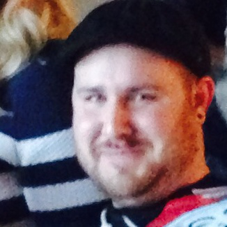

True age group: 4
True gender: 1
Predicted age group: 4
Predicted gender: 1


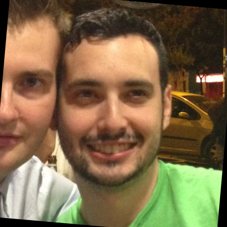

True age group: 4
True gender: 1
Predicted age group: 4
Predicted gender: 1


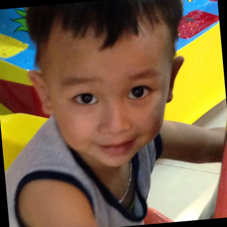

True age group: 0
True gender: 1
Predicted age group: 1
Predicted gender: 1


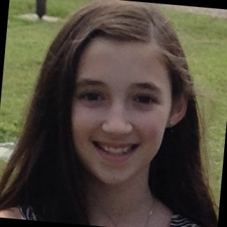

True age group: 2
True gender: 0
Predicted age group: 2
Predicted gender: 0


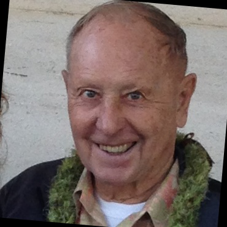

True age group: 7
True gender: 1
Predicted age group: 5
Predicted gender: 1


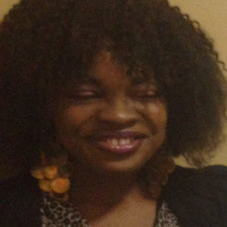

True age group: 4
True gender: 0
Predicted age group: 4
Predicted gender: 0


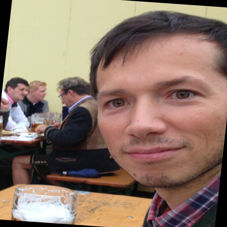

True age group: 4
True gender: 1
Predicted age group: 4
Predicted gender: 1


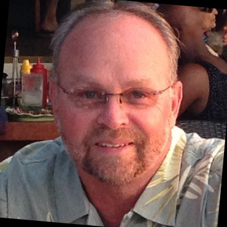

True age group: 7
True gender: 1
Predicted age group: 6
Predicted gender: 1


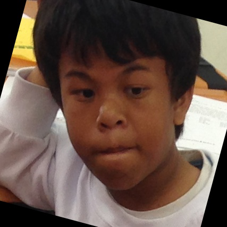

True age group: 3
True gender: 1
Predicted age group: 2
Predicted gender: 1


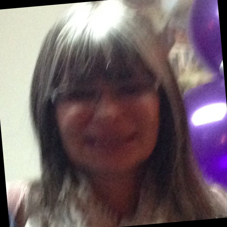

True age group: 7
True gender: 0
Predicted age group: 4
Predicted gender: 0


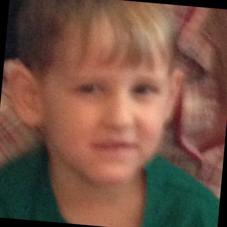

True age group: 2
True gender: 1
Predicted age group: 2
Predicted gender: 1


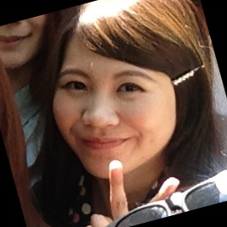

True age group: 3
True gender: 0
Predicted age group: 4
Predicted gender: 0


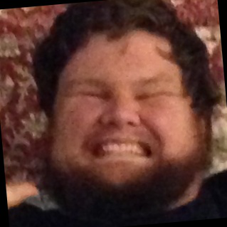

True age group: 4
True gender: 1
Predicted age group: 4
Predicted gender: 1


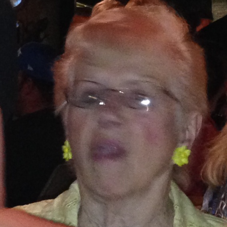

True age group: 7
True gender: 0
Predicted age group: 7
Predicted gender: 1


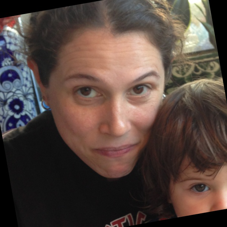

True age group: 4
True gender: 0
Predicted age group: 4
Predicted gender: 0


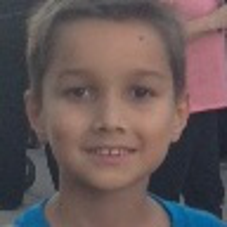

True age group: 2
True gender: 1
Predicted age group: 2
Predicted gender: 0


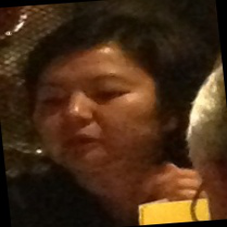

True age group: 6
True gender: 0
Predicted age group: 4
Predicted gender: 0


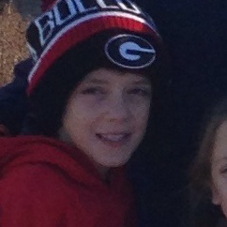

True age group: 2
True gender: 1
Predicted age group: 2
Predicted gender: 0


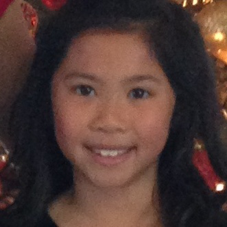

True age group: 2
True gender: 0
Predicted age group: 2
Predicted gender: 0


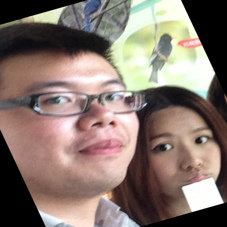

True age group: 3
True gender: 1
Predicted age group: 4
Predicted gender: 1


In [ ]:
from tensorflow import keras

import tensorflow as tf
import PIL
import PIL.Image
import numpy as np
import pickle

def numpy_to_tensor(numpy_input):
    tensor = tf.convert_to_tensor(numpy_input, dtype=tf.float32)
    return tf.expand_dims(tensor, axis=0)

def try_model(index):
    display(PIL.Image.fromarray(np.uint8(test_images[index])))
    #age truth
    print(f"True age group: {np.where(y_age_test_one_hot[index]==1)[0][0]}")

    #gender truth
    print(f"True gender: {np.where(y_gender_test_one_hot[index]==1)[0][0]}")

    # age
    print(f"Predicted age group: {np.argmax(model.predict(numpy_to_tensor(test_images[index]))[0])}")
    # gender
    print(f"Predicted gender: {np.argmax(model.predict(numpy_to_tensor(test_images[index]))[1])}")

from random import randrange

for i in range(20):
    try_model(randrange(len(test_images)))

# Gender accuracy and loss against epoch

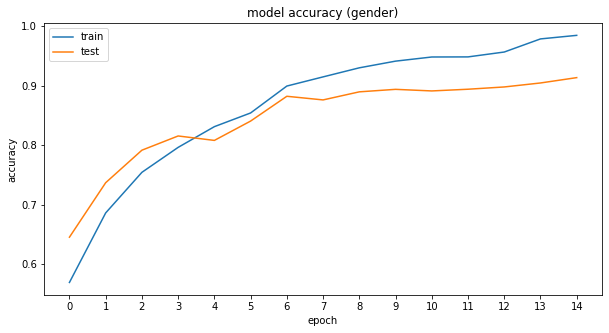

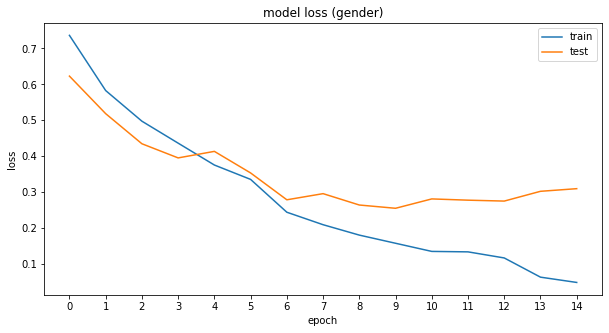

In [ ]:
# Plot accuracies of training and test data
plt.figure(figsize=(10,5))
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.xticks(range(15))
plt.title('model accuracy (gender)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

# Plot accuracies of training and test data
plt.figure(figsize=(10,5))
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.xticks(range(15))
plt.title('model loss (gender)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

# Age accuracy and loss against epoch

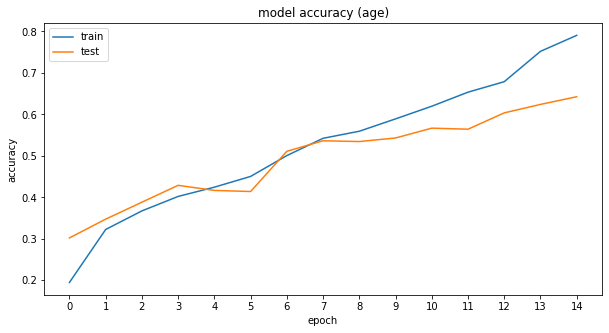

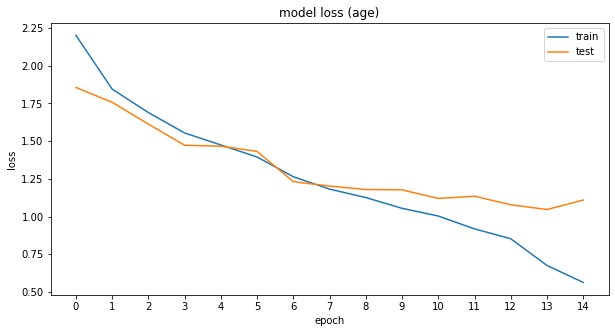

In [ ]:
# Plot accuracies of training and test data
plt.figure(figsize=(10,5))
plt.plot(history.history['age_output_accuracy'])
plt.plot(history.history['val_age_output_accuracy'])
plt.xticks(range(15))
plt.title('model accuracy (age)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

# Plot accuracies of training and test data
plt.figure(figsize=(10,5))
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.xticks(range(15))
plt.title('model loss (age)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

# Classfication report (Gender)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

y_pred = model.predict(test_images)
proba = y_pred[1].max(axis=1).reshape(-1, 1)
y_proba_positive = y_pred[1][:,1:]
y_pred_one_hot = np.where(y_pred[1] == proba, 1, 0)
y_pred_int = [np.where(r==1)[0][0] for r in y_pred_one_hot]

y_true = [np.where(r==1)[0][0] for r in y_gender_test_one_hot]

2021-11-14 16:26:32.042861: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 809417532 exceeds 10% of free system memory.


In [ ]:
accuracy = accuracy_score(y_true, y_pred_int)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_int)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_int)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_int)
print('F1 score: %f' % f1)

# ROC AUC
auc = roc_auc_score(y_true, y_proba_positive.flatten())
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_true, y_pred_int)
print(matrix)

Accuracy: 0.913293
Precision: 0.919342
Recall: 0.896469
F1 score: 0.907761
ROC AUC: 0.968645
[[2548  196]
 [ 258 2234]]


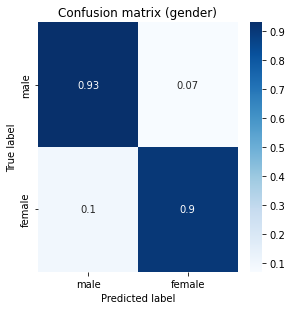

In [ ]:
classes=['male','female']

con_mat_norm = np.around(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(4, 4))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues,)
plt.tight_layout()
plt.title('Confusion matrix (gender)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ROC curve (Gender)

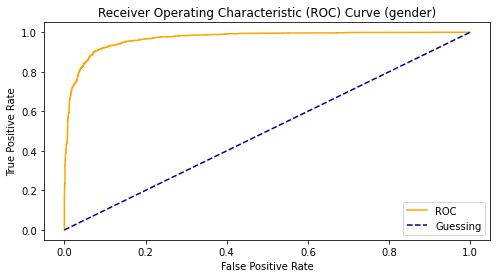

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr , tpr , thresholds = roc_curve (y_true , y_proba_positive.flatten())

def plot_roc_curve(fpr, tpr):
    """
    Plots a ROC curve given the false positve rate (fpr) and 
    true postive rate (tpr) of a classifier.
    """
    # Plot ROC curve
    figure = plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Guessing')
    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (gender)')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

# Classification report (Age)

In [ ]:
proba = y_pred[0].max(axis=1).reshape(-1, 1)
y_proba_positive = y_pred[0][:,1:]
y_pred_one_hot = np.where(y_pred[0] == proba, 1, 0)
y_pred_int = [np.where(r==1)[0][0] for r in y_pred_one_hot]

y_true = [np.where(r==1)[0][0] for r in y_age_test_one_hot]

In [ ]:
accuracy = accuracy_score(y_true, y_pred_int)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_int,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_int,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_int,average='weighted')
print('F1 score: %f' % f1)

# confusion matrix
matrix = confusion_matrix(y_true, y_pred_int)
print(matrix)

Accuracy: 0.642666
Precision: 0.638061
Recall: 0.642666
F1 score: 0.626837
[[ 306  110    1    0    4    1    0    0]
 [  49  527   28    4   14    3    0    0]
 [   1  108  429   32   85    7    0    0]
 [   0   14   47  271  197   28    1    0]
 [   2   12   64   90 1272  112    3    3]
 [   0    1   13   21  411  410    9   14]
 [   0    3    3    2   66  137   27   29]
 [   2    5    3    8   22   75   27  123]]


# Confusion matrix (Age)

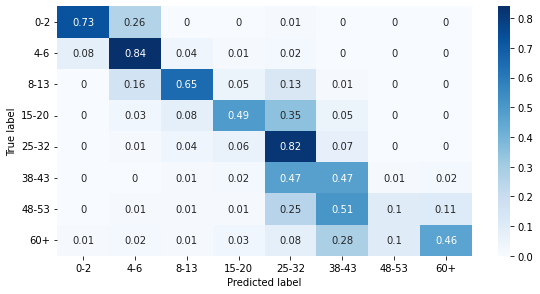

In [ ]:
classes=['0-2',
    '4-6',
    '8-13',
    '15-20',
    '25-32',
    '38-43',
    '48-53',
    '60+']

    

con_mat_norm = np.around(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 4))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues,)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

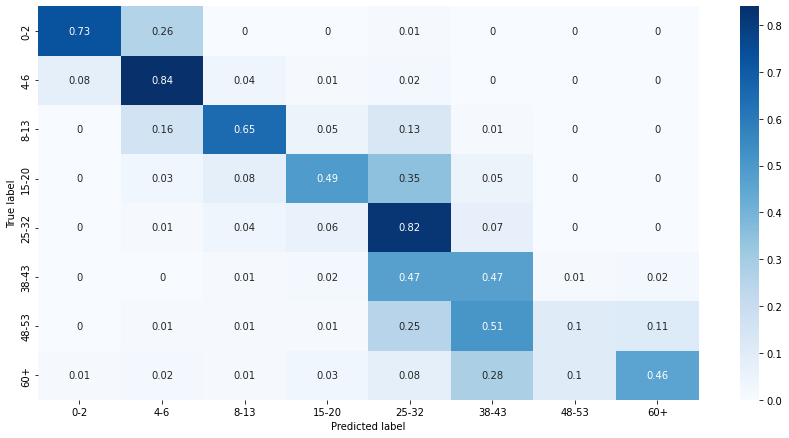

In [ ]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues,)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()